## **Version D: Contrastive Learning (CL) + EfficientNet Only**

**STEP 1: Setup and Imports**

In [ ]:
# Install dependencies
!pip install -q torch torchvision gdown

# Imports
import os
import random
import zipfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.0 MB/s eta 0:00:00
Device: cuda


**STEP 2: Download and Prepare Dataset**

In [ ]:
import gdown

# Download and unzip dataset
gdown.download("https://drive.google.com/uc?id=1RZ2MXgM_6ehgMYOFhjBQHMJO1ZdgiEnG", "Real_and_Fake_Dataset.zip", quiet=False)
with zipfile.ZipFile("Real_and_Fake_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("./Real_and_Fake_Dataset")
os.remove("Real_and_Fake_Dataset.zip")

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
full_dataset = ImageFolder(root="./Real_and_Fake_Dataset/real_and_fake_face", transform=transform)

# Split dataset
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Downloading...
From (original): https://drive.google.com/uc?id=1RZ2MXgM_6ehgMYOFhjBQHMJO1ZdgiEnG
From (redirected): https://drive.google.com/uc?id=1RZ2MXgM_6ehgMYOFhjBQHMJO1ZdgiEnG&confirm=t&uuid=61aaba6f-3bf4-4239-89d5-ecc0764fe5b3
To: /content/Real_and_Fake_Dataset.zip
100%|██████████| 452M/452M [00:05<00:00, 77.6MB/s]


Train: 1428 | Val: 306 | Test: 307


**STEP 3: Build EfficientNet + Contrastive Head**

In [ ]:
class ContrastiveEfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.base.classifier[1] = nn.Identity()
        self.projector = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )
        self.classifier = nn.Linear(128, 2)

    def forward(self, x, contrastive_only=False):
        features = self.base(x)
        projection = self.projector(features)
        if contrastive_only:
            return projection
        return self.classifier(projection), projection

model = ContrastiveEfficientNet().to(device)



Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 64.1MB/s]


**STEP 4: Train with Contrastive + CE Loss**

In [ ]:
ce_loss = nn.CrossEntropyLoss()


def contrastive_loss(z1, z2):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    return 1 - F.cosine_similarity(z1, z2).mean()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_losses, val_losses = [], []

for epoch in range(20):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Two augmentations
        noise = torch.randn_like(images) * 0.05
        aug1 = torch.clamp(images + noise, 0, 1)
        aug2 = transforms.RandomHorizontalFlip(p=1.0)(images)

        outputs, z1 = model(aug1)
        _, z2 = model(aug2)

        loss_ce = ce_loss(outputs, labels)
        loss_cl = contrastive_loss(z1, z2)
        loss = loss_ce + 1.0 * loss_cl

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            loss = ce_loss(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

torch.save(model, "gendf_versionD.pth")
print("Model saved as gendf_versionD.pth")

from google.colab import files
files.download("gendf_versionD.pth")


Epoch 1: Train Loss = 0.7776, Val Loss = 0.7055
Epoch 2: Train Loss = 0.6559, Val Loss = 0.7065
Epoch 3: Train Loss = 0.5489, Val Loss = 0.8385
Epoch 4: Train Loss = 0.4185, Val Loss = 1.2266
Epoch 5: Train Loss = 0.2909, Val Loss = 1.4025
Epoch 6: Train Loss = 0.2085, Val Loss = 1.5349
Epoch 7: Train Loss = 0.1412, Val Loss = 1.3584
Epoch 8: Train Loss = 0.1333, Val Loss = 1.4299
Epoch 9: Train Loss = 0.1183, Val Loss = 1.4636
Epoch 10: Train Loss = 0.1027, Val Loss = 1.3403
Epoch 11: Train Loss = 0.0740, Val Loss = 1.9042
Epoch 12: Train Loss = 0.0563, Val Loss = 1.6946
Epoch 13: Train Loss = 0.0566, Val Loss = 1.3996
Epoch 14: Train Loss = 0.0361, Val Loss = 3.5468
Epoch 15: Train Loss = 0.0495, Val Loss = 1.3507
Epoch 16: Train Loss = 0.0537, Val Loss = 2.2488
Epoch 17: Train Loss = 0.0632, Val Loss = 2.7059
Epoch 18: Train Loss = 0.0340, Val Loss = 3.4906
Epoch 19: Train Loss = 0.0318, Val Loss = 4.5218
Epoch 20: Train Loss = 0.0647, Val Loss = 1.4427
Model saved as gendf_versionD

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Version D Testing**

### **01. Model Testing for Version D**


 Starting Model Evaluation on Validation Set (Version D)...

 Evaluation Metrics (Version D):
• Accuracy  : 0.6634
• F1 Score  : 0.7431
• Precision : 0.6535
• Recall    : 0.8613
• Confusion Matrix:
 [[ 54  79]
 [ 24 149]]


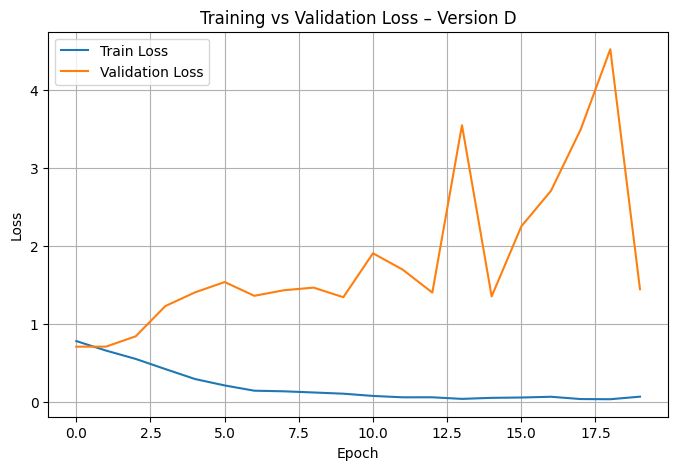


 Calculating AUC and plotting ROC Curve...
• AUC Score : 0.7187


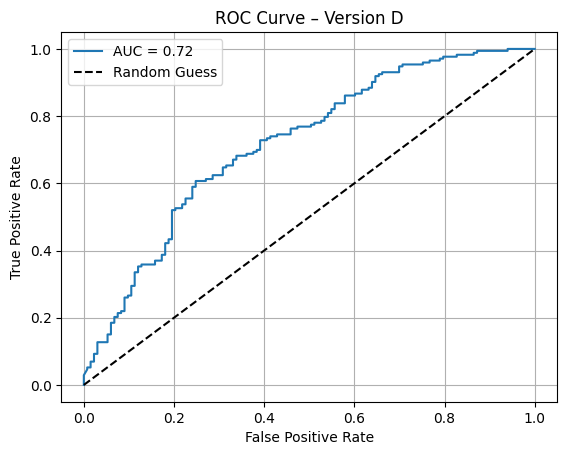

In [ ]:
# -------------------------------
# MODEL EVALUATION AND METRICS – Version D (CL only)
# -------------------------------

print("\n Starting Model Evaluation on Validation Set (Version D)...")

# Set model to evaluation mode
model.eval()

# Containers to collect predictions and labels
all_preds = []
all_labels = []

# Evaluate model on the validation set
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs, _ = model(images)  # Unpack logits and projection
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Compute evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print("\n Evaluation Metrics (Version D):")
print(f"• Accuracy  : {accuracy:.4f}")
print(f"• F1 Score  : {f1:.4f}")
print(f"• Precision : {precision:.4f}")
print(f"• Recall    : {recall:.4f}")
print("• Confusion Matrix:\n", conf_matrix)

# -------------------------------
# Check for Overfitting – Version D
# -------------------------------
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss – Version D")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# ROC Curve + AUC Score – Version D
# -------------------------------

from sklearn.metrics import roc_auc_score, roc_curve

print("\n Calculating AUC and plotting ROC Curve...")

all_probs = []

with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        outputs, _ = model(images)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs[:, 1])

auc = roc_auc_score(all_labels, all_probs)
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

print(f"• AUC Score : {auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Version D")
plt.legend()
plt.grid(True)
plt.show()


### **02. Functional Testing for version D**

In [ ]:
# UNIT TEST SUITE – Version D (CL only)

import unittest
import torch
import numpy as np
from PIL import Image

class TestVersionD(unittest.TestCase):

    def test_model_forward_pass(self):
        """
        Test if ContrastiveEfficientNet returns correct output and projection shapes.
        """
        model = ContrastiveEfficientNet()
        model.eval()
        dummy_input = torch.randn(1, 3, 224, 224)
        logits, projection = model(dummy_input)
        self.assertEqual(logits.shape, (1, 2), "Output shape should be (1, 2)")
        self.assertEqual(projection.shape[1], 128, "Projection shape should be (B, 128)")

    def test_model_output_no_nan(self):
        """
        Ensure model output does not contain NaNs.
        """
        model = ContrastiveEfficientNet()
        model.eval()
        dummy_input = torch.randn(1, 3, 224, 224)
        output, _ = model(dummy_input)
        self.assertFalse(torch.isnan(output).any(), "Model output contains NaNs.")

    def test_invalid_input_shape(self):
        """
        Verify model raises error or handles incorrect input shape.
        """
        model = ContrastiveEfficientNet()
        model.eval()
        invalid_input = torch.randn(1, 3, 100, 100)
        try:
            output, _ = model(invalid_input)
            self.assertEqual(output.shape, (1, 2))
        except Exception:
            pass  # Acceptable if model throws error on bad shape

    def test_grayscale_image_handling(self):
        """
        Check if model can process grayscale image converted to RGB.
        """
        gray_img = Image.new('L', (224, 224)).convert("RGB")
        transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
        input_tensor = transform(gray_img).unsqueeze(0)
        model = ContrastiveEfficientNet()
        model.eval()
        try:
            logits, _ = model(input_tensor)
            self.assertEqual(logits.shape, (1, 2))
        except Exception as e:
            self.fail(f"Model failed on grayscale image input: {e}")

# Run tests
suite = unittest.TestLoader().loadTestsFromTestCase(TestVersionD)
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)


test_grayscale_image_handling (__main__.TestVersionD.test_grayscale_image_handling)
Check if model can process grayscale image converted to RGB. ... ok
test_invalid_input_shape (__main__.TestVersionD.test_invalid_input_shape)
Verify model raises error or handles incorrect input shape. ... ok
test_model_forward_pass (__main__.TestVersionD.test_model_forward_pass)
Test if ContrastiveEfficientNet returns correct output and projection shapes. ... ok
test_model_output_no_nan (__main__.TestVersionD.test_model_output_no_nan)
Ensure model output does not contain NaNs. ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.902s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

### **03. Non-Functional Testing for Version D**

In [ ]:
print("\nNon-Functional Testing – Version D (CL Only + EfficientNet)")

import time
import psutil  # Ensure psutil is imported

# 1. Accuracy Threshold Check (NFR03)
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)  # Model returns (logits, projection)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
accuracy = correct / total
print(f"\nAccuracy: {accuracy:.2%}")
print("Passed" if accuracy >= 0.75 else "Failed", ": Accuracy threshold (75%)")

# 2. Performance Testing (Inference Speed)
timings = []
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.to(device)
        start = time.time()
        _ = model(images)
        end = time.time()
        timings.append(end - start)
        if i == 5: break  # Only measure first 6 batches
avg_inf_time = np.mean(timings)
print(f"\nAverage Inference Time (per batch): {avg_inf_time:.4f} seconds")

# 3. Load & Scalability Proxy (Resource Check)
print("\nCPU Usage:", psutil.cpu_percent(interval=1), "%")
print("RAM Usage:", psutil.virtual_memory().percent, "%")

# 4. Security Validation
print("\n Security Note: All processing is done in-memory. No images or labels are stored or logged.")

# 5. Known Limitations
print("\n Note: This model is designed specifically for detecting deepfakes in human facial images. It may misclassify non-facial or abstract inputs.")



Non-Functional Testing – Version D (CL Only + EfficientNet)

Accuracy: 66.45%
Failed : Accuracy threshold (75%)

Average Inference Time (per batch): 0.0100 seconds

CPU Usage: 5.5 %
RAM Usage: 19.8 %

 Security Note: All processing is done in-memory. No images or labels are stored or logged.

 Note: This model is designed specifically for detecting deepfakes in human facial images. It may misclassify non-facial or abstract inputs.


### **04. Edge case Testing for Version D**

In [ ]:
# EDGE CASE TESTING – Version D (CL Only + EfficientNet)

import unittest
import torch
import numpy as np
from PIL import Image

class TestEdgeCasesD(unittest.TestCase):

    def test_empty_image_input(self):
        model.eval()
        blank = torch.zeros(1, 3, 224, 224).to(device)
        try:
            output, _ = model(blank)
            self.assertEqual(output.shape, (1, 2))
        except Exception as e:
            self.fail(f"Model failed on empty image input: {e}")

    def test_grayscale_input_to_model(self):
        gray_img = Image.new('L', (224, 224)).convert("RGB")
        tensor = transform(gray_img).unsqueeze(0).to(device)
        try:
            output, _ = model(tensor)
            self.assertEqual(output.shape, (1, 2))
        except Exception as e:
            self.fail(f"Model failed on grayscale input: {e}")

    def test_large_image_resizing(self):
        large_img = Image.new('RGB', (512, 512))
        tensor = transform(large_img.resize((224, 224))).unsqueeze(0).to(device)
        try:
            output, _ = model(tensor)
            self.assertEqual(output.shape, (1, 2))
        except Exception as e:
            self.fail(f"Model failed on large image input: {e}")

    def test_random_noise_image(self):
        noise_img = torch.randn(1, 3, 224, 224).to(device)
        try:
            output, _ = model(noise_img)
            self.assertEqual(output.shape, (1, 2))
        except Exception as e:
            self.fail(f"Model failed on random noise input: {e}")

# Run Edge Case Test Suite
edge_suite = unittest.TestLoader().loadTestsFromTestCase(TestEdgeCasesD)
runner = unittest.TextTestRunner(verbosity=2)
runner.run(edge_suite)


test_empty_image_input (__main__.TestEdgeCasesD.test_empty_image_input) ... ok
test_grayscale_input_to_model (__main__.TestEdgeCasesD.test_grayscale_input_to_model) ... ok
test_large_image_resizing (__main__.TestEdgeCasesD.test_large_image_resizing) ... ok
test_random_noise_image (__main__.TestEdgeCasesD.test_random_noise_image) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.151s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

### **05. Grad-CAM Testing for Version D**

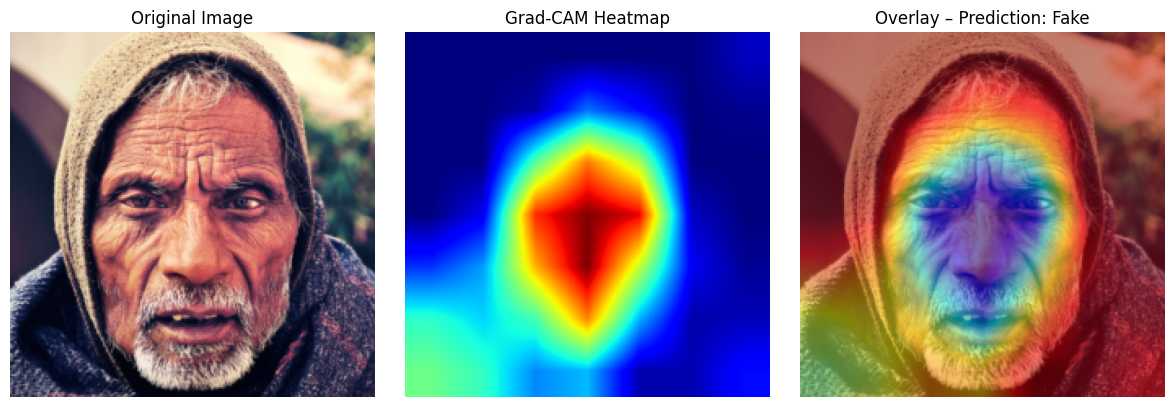

In [ ]:
# GRAD-CAM TEST – Version D (CL Only + EfficientNet)

import cv2

model.eval()

# Step 1: Select a sample image
test_iter = iter(test_loader)
images, labels = next(test_iter)
input_img = images[0].unsqueeze(0).to(device)
label = labels[0]

# Step 2: Setup Grad-CAM hooks
gradients = []
feature_maps = []

def forward_hook(module, input, output):
    feature_maps.append(output)
    output.register_hook(lambda grad: gradients.append(grad))

target_layer = model.base.features[-1]
hook_handle = target_layer.register_forward_hook(forward_hook)

# Step 3: Forward and backward pass
output, _ = model(input_img)
pred_class = torch.argmax(output, dim=1).item()

model.zero_grad()
output[0, pred_class].backward()

# Step 4: Generate CAM
grads_val = gradients[0].squeeze().cpu().detach().numpy()
feature_maps_val = feature_maps[0].squeeze().cpu().detach().numpy()

weights = np.mean(grads_val, axis=(1, 2))
cam = np.zeros(feature_maps_val.shape[1:], dtype=np.float32)
for i, w in enumerate(weights):
    cam += w * feature_maps_val[i]

cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (224, 224))
cam -= np.min(cam)
cam /= np.max(cam + 1e-8)  # avoid division by zero

# Step 5: Overlay CAM on image
img_np = input_img.cpu().squeeze().permute(1, 2, 0).numpy()
img_np = img_np - np.min(img_np)
img_np = img_np / np.max(img_np + 1e-8)

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlay = heatmap + img_np
overlay = overlay / np.max(overlay + 1e-8)

# Step 6: Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cam, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay – Prediction: {'Fake' if pred_class == 1 else 'Real'}")
plt.axis("off")
plt.tight_layout()
plt.show()

# Unhook
hook_handle.remove()
